In [55]:
import scipy.io

import os
import time

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
from scipy import stats

In [56]:
mat = scipy.io.loadmat('Oxford_Battery_Degradation_Dataset_1.mat')

In [57]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Cell1', 'Cell2', 'Cell3', 'Cell4', 'Cell5', 'Cell6', 'Cell7', 'Cell8'])

In [58]:
input_data = [
    [[], []],
    [[], []],
    [[], []],
    [[], []],
    [[], []],
    [[], []],
    [[], []],
    [[], []]
]

CELL_SIZE = [83, 78, 82, 52, 51, 51, 82, 82]

In [59]:
for i in range(0, 8):
    cell_num = "Cell{}".format(i + 1)
    for j in range(0, CELL_SIZE[i]):
        cyc_num = "cyc{:04d}".format(j * 100)
        try:
            curr = mat[cell_num][0][cyc_num][0][0]["C1ch"][0][0]['q'][0][-1][0]
        except ValueError:
            curr = float("NaN")
        input_data[i][0].append(j)
        input_data[i][1].append(curr)

In [60]:
train_x = []
train_y = []
test_x = []
test_y = []

In [61]:
count = 1

for i in range(0, 5):
    df_input = pd.DataFrame(input_data[i]).transpose()
    df_input = df_input.rename(columns={0: "cycle", 1: "q_value"})
    df_input['interpolate_spline'] = df_input['q_value'].interpolate(option='spline')
    df_input['soh'] = df_input['interpolate_spline'] / 740

    df_input = df_input.drop("cycle", axis=1)
    df_input = df_input.drop("q_value", axis=1)
    df_input = df_input.drop("interpolate_spline", axis=1)

    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df_input.values)
    label_sc.fit(df_input.iloc[:, 0].values.reshape(-1, 1))

    lookback = 10
    inputs = np.zeros((len(data) - lookback, lookback, df_input.shape[1]))
    labels = np.zeros(len(data) - lookback)

    for i in range(lookback, len(data)):
        inputs[i - lookback] = data[i - lookback:i]
        labels[i - lookback] = data[i, 0]
    inputs = inputs.reshape(-1, lookback, df_input.shape[1])
    labels = labels.reshape(-1, 1)

    if (count < 5):
        if len(train_x) == 0:
            train_x = inputs[:]
            print(train_x)
            train_y = labels[:]
        else:
            train_x = np.concatenate((train_x, inputs[:]))
            train_y = np.concatenate((train_y, labels[:]))
    else:
        test_x = inputs
        test_y = labels

    count = count + 1

    # test_portion = int(0.2 * len(inputs))
    #
    # if len(train_x) == 0:
    #     train_x = inputs[:-test_portion]
    #     train_y = labels[:-test_portion]
    # else:
    #     train_x = np.concatenate((train_x, inputs[:-test_portion]))
    #     train_y = np.concatenate((train_y, labels[:-test_portion]))
    #
    # if len(test_x) == 0:
    #     test_x = inputs[-test_portion:]
    #     test_y = labels[-test_portion:]
    # else:
    #     test_x = np.concatenate((test_x, inputs[-test_portion:]))
    #     test_y = np.concatenate((test_y, labels[-test_portion:]))

[[[1.        ]
  [0.95075689]
  [0.92671186]
  [0.91225103]
  [0.88756713]
  [0.87015102]
  [0.85289598]
  [0.83341703]
  [0.8125442 ]
  [0.79517458]]

 [[0.95075689]
  [0.92671186]
  [0.91225103]
  [0.88756713]
  [0.87015102]
  [0.85289598]
  [0.83341703]
  [0.8125442 ]
  [0.79517458]
  [0.77879722]]

 [[0.92671186]
  [0.91225103]
  [0.88756713]
  [0.87015102]
  [0.85289598]
  [0.83341703]
  [0.8125442 ]
  [0.79517458]
  [0.77879722]
  [0.76229649]]

 [[0.91225103]
  [0.88756713]
  [0.87015102]
  [0.85289598]
  [0.83341703]
  [0.8125442 ]
  [0.79517458]
  [0.77879722]
  [0.76229649]
  [0.74626657]]

 [[0.88756713]
  [0.87015102]
  [0.85289598]
  [0.83341703]
  [0.8125442 ]
  [0.79517458]
  [0.77879722]
  [0.76229649]
  [0.74626657]
  [0.72997125]]

 [[0.87015102]
  [0.85289598]
  [0.83341703]
  [0.8125442 ]
  [0.79517458]
  [0.77879722]
  [0.76229649]
  [0.74626657]
  [0.72997125]
  [0.7151503 ]]

 [[0.85289598]
  [0.83341703]
  [0.8125442 ]
  [0.79517458]
  [0.77879722]
  [0.76229649

In [62]:
np.array(train_x).shape

(255, 10, 1)

In [63]:
np.array(train_y).shape

(255, 1)

In [64]:
np.array(test_x).shape

(41, 10, 1)

In [65]:
batch_size = 32
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [66]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [67]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:, -1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [68]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=100, model_type="GRU"):
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 2
    # Instantiating the models

    model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)

    model.to(device)

    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1, EPOCHS + 1):
        start_time = time.process_time()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            h = h.data
            model.zero_grad()

            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()

            print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter,
                                                                                       len(train_loader),
                                                                                       avg_loss / counter))
        current_time = time.process_time()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss / len(train_loader)))
        print("Total Time Elapsed: {} seconds".format(str(current_time - start_time)))
        epoch_times.append(current_time - start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

In [69]:
def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.process_time()

    inp = torch.from_numpy(np.array(test_x))
    labs = torch.from_numpy(np.array(test_y))
    h = model.init_hidden(inp.shape[0])
    out, h = model(inp.to(device).float(), h)
    outputs.append(label_sc.inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    targets.append(label_sc.inverse_transform(labs.numpy()).reshape(-1))

    print("Evaluation Time: {}".format(str(time.process_time() - start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i] - targets[i]) / (targets[i] + outputs[i]) / 2) / len(outputs)
    print("sMAPE: {}%".format(sMAPE * 100))
    return outputs, targets, sMAPE

In [70]:
lr = 0.001
gru_model = train(train_loader, lr, model_type="GRU")

Starting Training of GRU model
Epoch 1......Step: 1/7....... Average Loss for Epoch: 0.1566334217786789
Epoch 1......Step: 2/7....... Average Loss for Epoch: 0.14693795144557953
Epoch 1......Step: 3/7....... Average Loss for Epoch: 0.11922642836968105
Epoch 1......Step: 4/7....... Average Loss for Epoch: 0.10395742580294609
Epoch 1......Step: 5/7....... Average Loss for Epoch: 0.09553886279463768
Epoch 1......Step: 6/7....... Average Loss for Epoch: 0.08826310684283574
Epoch 1......Step: 7/7....... Average Loss for Epoch: 0.08207065186330251
Epoch 1/100 Done, Total Loss: 0.08207065186330251
Total Time Elapsed: 1.15625 seconds
Epoch 2......Step: 1/7....... Average Loss for Epoch: 0.03877151012420654
Epoch 2......Step: 2/7....... Average Loss for Epoch: 0.044488925486803055
Epoch 2......Step: 3/7....... Average Loss for Epoch: 0.04567007223765055
Epoch 2......Step: 4/7....... Average Loss for Epoch: 0.04715811647474766
Epoch 2......Step: 5/7....... Average Loss for Epoch: 0.0446961939334

In [71]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_sc)

# MAE and RMSE
# predicted curve
# performance, numerical results


Evaluation Time: 0.078125
sMAPE: 0.5571775456072083%


In [72]:
gru_outputs

[array([0.9026593 , 0.89882606, 0.8949764 , 0.8911573 , 0.8873884 ,
        0.88370246, 0.8800462 , 0.8763732 , 0.8725236 , 0.868451  ,
        0.8642456 , 0.86001706, 0.8557459 , 0.85170954, 0.84783536,
        0.84403205, 0.84021604, 0.83642256, 0.8327471 , 0.8292339 ,
        0.8258159 , 0.82266694, 0.81955886, 0.81639653, 0.813291  ,
        0.81021637, 0.8071416 , 0.8042205 , 0.80077976, 0.79752535,
        0.79470545, 0.79200536, 0.7891512 , 0.78637683, 0.7835565 ,
        0.78065723, 0.7776628 , 0.77488816, 0.7722649 , 0.7697011 ,
        0.7444099 ], dtype=float32)]

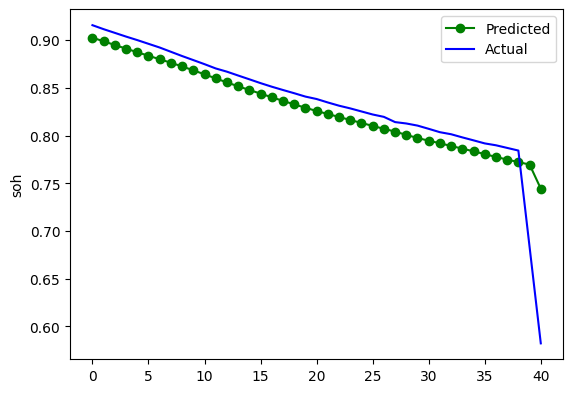

In [73]:
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
plt.plot(gru_outputs[0][-100:], "-o", color="g", label="Predicted")
plt.plot(targets[0][-100:], color="b", label="Actual")
plt.ylabel('soh')
plt.legend()